# Visualization_of_station_location_and_BC_map

In [1]:
import sys
import glob
import h5py

import numpy as np
import pandas as pd
import netCDF4 as nc

In [2]:
sys.path.insert(0, '/glade/u/home/ksha/WORKSPACE/QC_OBS/')
sys.path.insert(0, '/glade/u/home/ksha/WORKSPACE/QC_OBS/utils/')
sys.path.insert(0, '/glade/u/home/ksha/WORKSPACE/utils/')

import data_utils as du
import graph_utils as gu
from namelist import *

In [3]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.patches as patches
from matplotlib.patches import Polygon, PathPatch
from matplotlib.collections import PatchCollection

# import plotting libraries
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.feature import ShapelyFeature
from cartopy.io.shapereader import Reader
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
%matplotlib inline

In [4]:
RB = [0.25, 0.41, 0.88]  # Royal blue
AM = [0.90, 0.17, 0.31]  # Amathran

JET = []
JET.append(gu.xcolor('indian red'))
JET.append(gu.xcolor('gold'))
JET.append(gu.xcolor('dark sea green'))
JET.append(gu.xcolor('deep sky blue'))
JET.append(gu.xcolor('royal blue'))
#JET = JET[::-1]

# base_dir = '/Users/yingkai/Repository/WRFT/_data/nowcast_op/'
# gis_dir = '/Users/yingkai/Repository/WRFT/_data/GIS_Info/'
base_dir = '/glade/scratch/ksha/BACKUP/'
fig_dir = '/glade/u/home/ksha/figures/'

Switch between **Canadian DEM hires** and **ETOPO**

In [5]:
hdf_io = h5py.File(base_dir+'CDEM_original.hdf', 'r') #CDEM_original.hdf
CDEM = hdf_io['CDEM'][...]
nav_lon = hdf_io['CDEM_lon'][...]
nav_lat = hdf_io['CDEM_lat'][...]
hdf_io.close()

# with nc.Dataset(base_dir+'etopo5.nc') as nc_obj:
#     etopo_x = nc_obj.variables['topo_lon'][...]
#     etopo_y = nc_obj.variables['topo_lat'][...]
#     CDEM = nc_obj.variables['topo'][...].astype(float)
# nav_lon, nav_lat = np.meshgrid(etopo_x, etopo_y)
CDEM[CDEM<=0]=np.nan
#print(hdf_io.keys())

# Number of samples to be QC'd per station

In [ ]:
with pd.HDFStore(base_dir+'BCH_metadata.hdf', 'r') as hdf_temp:
    metadata = hdf_temp['metadata']

stn_code = metadata['code'].values.tolist()
stn_lat = metadata['lat'].values
stn_lon = metadata['lon'].values
stn_elev = metadata['elev [m]'].values

In [7]:
N_sample = {
    'ILL': 5893,
    'GOL': 5180,
    'HFG': 3114,
    'KEY': 2643,
    'MSK': 1064,
    'PKA': 691,
    'PMD': 2508,
    'SKI': 176,
    'TNS': 1118,
    'WCC': 3339,
    'WRU': 63,
    'AKI': 2925,
    'AKN': 2006,
    'ALU': 13756,
    'ASH': 6816,
    'BAR': 2045,
    'BIR': 3808,
    'BLN': 6719,
    'BMN': 2062,
    'BRI': 4228,
    'BUL': 2794,
    'BVR': 13368,
    'CHK': 4662,
    'CHW': 3705,
    'CLO': 5359,
    'CLW': 7921,
    'CMX': 4476,
    'COQ': 14311,
    'COX': 4595,
    'CQM': 8588,
    'DAI': 3870,
    'DBC': 5183,
    'DCN': 3507,
    'DLU': 2724,
    'DON': 3288,
    'DOW': 10725,
    'EAC': 3457,
    'ELK': 4811,
    'ELR': 14599,
    'ERC': 4426,
    'FDL': 4846,
    'FER': 4307,
    'FIN': 2809,
    'FLK': 2954,
    'FST': 10357,
    'GLD': 6974,
    'GOC': 6265,
    'GOL': 5180,
    'GRN': 4831,
    'GRP': 6854,
    'GRT': 13424,
    'HEB': 5086,
    'HFF': 2844,
    'HRN': 3694,
    'HUR': 6596,
    'ILL': 5893,
    'JHT': 6239,
    'KEY': 2643,
    'MCQ': 4870,
    'MIS': 2200,
    'MOB': 4247,
    'MOL': 3269,
    'MOR': 2811,
    'MTR': 3935,
    'NTY': 3461,
    'PAK': 5974,
    'PAR': 3253,
    'PNK': 2849,
    'PRS': 3813,
    'PUL': 3480,
    'PYN': 3522,
    'QBY': 1926,
    'SGL': 14298,
    'SHH': 3670,
    'SLK': 4370,
    'STA': 9187,
    'STV': 5777,
    'UCE': 2865,
    'WAH': 5390,
    'WOL': 5350,
    'WON': 2070,
    'YGS': 1041,
    'KWA': 4124}

In [8]:
with pd.HDFStore(base_dir+'BCH_combine.hdf', 'r') as hdf_temp:
    keys = hdf_temp.keys()
    
keys = du.del_slash(keys)
inds = du.str_search(stn_code, keys)
L = len(stn_code); flag_pick = du.ind_to_flag(inds, L)

duplicate items (will pick the last one)
1 --> GOL
56 --> GOL
duplicate items (will pick the last one)
0 --> ILL
64 --> ILL
duplicate items (will pick the last one)
3 --> KEY
66 --> KEY


# Separate stations by watershed groups

In [9]:
#rocky = [-119, -114, 48, 54]

south = [-130, -121, 48.75, 50.25]
north = [-127.5, -110, 53, 60]

loc_id = [] # 0 van isl, 1 south, 2 rocky, 3 north

for i in range(len(stn_code)):
    temp_lat = stn_lat[i]
    temp_lon = stn_lon[i]
    if du.check_bounds(temp_lon, temp_lat, south):
        loc_id.append(1)
    elif du.check_bounds(temp_lon, temp_lat, north):
        loc_id.append(3)
    else:
        loc_id.append(2)
        
loc_id = np.array(loc_id)
loc_pick = loc_id[flag_pick]

# metadata['zone'] = np.array(loc_id)
# with pd.HDFStore(base_dir+'BCH_metadata_zoned.hdf', 'w') as hdf_temp:
#     hdf_temp['metadata'] = metadata

In [10]:
stn_pick = np.array(stn_code)[flag_pick]
lon_pick = np.array(stn_lon)[flag_pick]
lat_pick = np.array(stn_lat)[flag_pick]

loc_pick = loc_id[flag_pick]

In [11]:
zone1 = {}
zone2 = {}
zone3 = {}
for i, key in enumerate(stn_pick):
    if loc_pick[i] == 1:
        zone1[key] = N_sample[key]
    elif loc_pick[i] == 2:
        zone2[key] = N_sample[key]        
    elif loc_pick[i] == 3:
        zone3[key] = N_sample[key] 

# Map settings

In [12]:
# Cartopy map settings
scale_param = '10m' # 10m for publication quality
# BC and Ca-US boundary
PROVINCE = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale=scale_param,
    facecolor='none')
shape_dir = fig_dir+'wshed_hires/MajorHydroWatershedsProject.shp'

In [13]:
name_list = ['United States of America']
geom_US = gu.get_country_geom(name_list)

Selecting: United States of America


In [15]:
# metadata['zone'] = loc_id

# with pd.HDFStore(base_dir+'BCH_metadata_zoned.hdf', 'w') as hdf_temp:
#     hdf_temp['metadata'] = metadata

from matplotlib import ticker
#import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# AGU poster version (yellow background)

In [16]:
# poster_c = '#F7E7CE'
# topo_level=np.arange(0, 3200, 200)
# edge = [-127.75, -114.42, 49, 58.25]
# s = 1
# fig = plt.figure(figsize=(13, 7), facecolor=poster_c)
# ax1 = fig.gca(projection=ccrs.PlateCarree())
# # ===== #
# ax = ax1
# ax.set_extent(edge, ccrs.Geodetic())
# ax.add_feature(cfeature.LAND.with_scale(scale_param), facecolor='0.75')
# ax.add_feature(cfeature.COASTLINE.with_scale(scale_param), zorder=3)
# ax.add_feature(cfeature.BORDERS.with_scale(scale_param), linestyle='--', linewidth=3.5, zorder=3)
# ax.add_feature(PROVINCE, edgecolor='k', linestyle='-', linewidth=3.5, zorder=3)
# ax.add_feature(cfeature.LAKES.with_scale(scale_param), linewidth=0, facecolor='k', zorder=5)
# ax.add_feature(cfeature.RIVERS.with_scale(scale_param), linewidth=0.5, edgecolor='k', zorder=5)
# ax.outline_patch.set_linewidth(2.5)
# ax.add_geometries(Reader(shape_dir).geometries(), ccrs.PlateCarree(),
#                   facecolor='none', edgecolor='0.25', linewidth=2.5, hatch='///')

# ax.add_geometries(geom_US, ccrs.PlateCarree(),
#                   facecolor='0.75', edgecolor='none', linewidth=0, zorder=6)
# #
# GL = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0)
# GL.xlabels_top = False
# GL.ylabels_right = False
# GL.xformatter = LONGITUDE_FORMATTER
# GL.yformatter = LATITUDE_FORMATTER
# GL.xlabel_style = {'size': 14}
# GL.ylabel_style = {'size': 14}
# GL.ylocator = mticker.FixedLocator([50, 52, 54, 56, 58, 60])
# GL.xlocator = mticker.FixedLocator([-126, -124, -122, -120, -118, -116])
# CS = ax.pcolormesh(nav_lon[::s, ::s], nav_lat[::s, ::s], CDEM[::s, ::s], vmin=0.001, vmax=2999, 
#                    cmap=plt.cm.terrain)

# handle1 = ax.plot(lon_pick[loc_pick==1], lat_pick[loc_pick==1], 'ro', mfc=JET[3], ms=12, mec='k', 
#                   mew=2.5, zorder=4, label='South Coast stations')
# handle2 = ax.plot(lon_pick[loc_pick==2], lat_pick[loc_pick==2], 'ro', mfc=JET[0], ms=12, mec='k', 
#                   mew=2.5, zorder=4, label='Southern Interior stations')
# handle3 = ax.plot(lon_pick[loc_pick==3], lat_pick[loc_pick==3], 'ro', mfc=JET[1], ms=12, mec='k', 
#                   mew=2.5, zorder=4, label='Northeast BC stations')

# handle_patch = patches.Patch(facecolor='none', edgecolor='0.25', linewidth=2.5, hatch='///', label='Watersheds')
# #
# ax_lg = fig.add_axes([0.8085, 0.883, 0.01, 0.01])
# ax_lg.set_axis_off()
# LG = ax_lg.legend(handles=[handle1[0], handle2[0], handle3[0], handle_patch], 
#                bbox_to_anchor=(0.5, 0.975), ncol=1, prop={'size':14}, fancybox=False)
# LG.get_frame().set_facecolor(poster_c)
# LG.get_frame().set_edgecolor('k')
# LG.get_frame().set_linewidth(2.5)
# LG.get_frame().set_alpha(1.0)

# ax_base = fig.add_axes([0.56, 0.6, 0.245, 0.105]) # 0.52, 0.2535, 0.4615, 0.07
# ax_base.set_facecolor(poster_c)
# [j.set_linewidth(2.5) for j in ax_base.spines.values()]
# ax_base.tick_params(axis='both', left=False, top=False, right=False, bottom=False, \
#                     labelleft=False, labeltop=False, labelright=False, labelbottom=False)
# cax = inset_axes(ax_base, width='100%', height='30%', borderpad=0, loc=9)
# CBar = plt.colorbar(CS, orientation='horizontal', cax=cax) 
# CBar.ax.tick_params(axis='x', labelsize=14, direction='in', length=0)
# CBar.set_label('Elevation [m]', fontsize=14)
# #CBar.ax.xaxis.set_ticks_position('top')
# #CBar.ax.xaxis.set_label_position('top')
# tick_locator = ticker.MaxNLocator(nbins=7)
# CBar.locator = tick_locator
# CBar.update_ticks()
# CBar.outline.set_linewidth(2.5)

# fig.savefig(fig_dir+'QC_stn_locs_poster.png', dpi=1000, orientation='portrait', \
#             papertype='a4', format='png', bbox_inches='tight', pad_inches=0.1, 
#             facecolor=fig.get_facecolor())

# Paper version

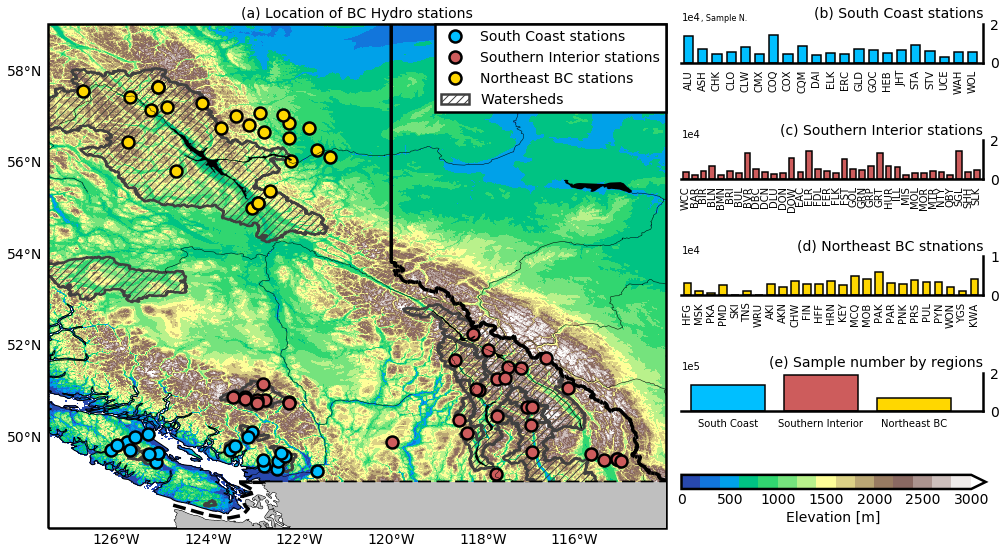

In [18]:
topo_level=np.arange(0, 3200, 200)
edge = [-127.5, -114, 48, 59]
s = 1
fig = plt.figure(figsize=(13, 7))
ax1 = plt.subplot2grid((5, 3), (0, 0), rowspan=5, colspan=2, projection=ccrs.PlateCarree())
ax2 = plt.subplot2grid((5, 3), (0, 2))
ax3 = plt.subplot2grid((5, 3), (1, 2))
ax4 = plt.subplot2grid((5, 3), (2, 2))
ax5 = plt.subplot2grid((5, 3), (3, 2))

plt.subplots_adjust(0, 0, 1, 1, hspace=2, wspace=0.05)
# ===== #
ax = ax1
ax.set_extent(edge, ccrs.Geodetic())
ax.add_feature(cfeature.LAND.with_scale(scale_param), facecolor='0.75')
ax.add_feature(cfeature.COASTLINE.with_scale(scale_param), zorder=3)
ax.add_feature(cfeature.BORDERS.with_scale(scale_param), linestyle='--', linewidth=3.5, zorder=3)
ax.add_feature(PROVINCE, edgecolor='k', linestyle='-', linewidth=3.5, zorder=3)
ax.add_feature(cfeature.LAKES.with_scale(scale_param), linewidth=0, facecolor='k', zorder=5)
ax.add_feature(cfeature.RIVERS.with_scale(scale_param), linewidth=0.5, edgecolor='k', zorder=5)
ax.outline_patch.set_linewidth(2.5)
ax.add_geometries(Reader(shape_dir).geometries(), ccrs.PlateCarree(),
                  facecolor='none', edgecolor='0.25', linewidth=2.5, hatch='///')

ax.add_geometries(geom_US, ccrs.PlateCarree(),
                  facecolor='0.75', edgecolor='none', linewidth=0, zorder=6)
#
GL = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0)
GL.xlabels_top = False
GL.ylabels_right = False
GL.xformatter = LONGITUDE_FORMATTER
GL.yformatter = LATITUDE_FORMATTER
GL.xlabel_style = {'size': 14}
GL.ylabel_style = {'size': 14}
GL.ylocator = mticker.FixedLocator([50, 52, 54, 56, 58, 60])
GL.xlocator = mticker.FixedLocator([-126, -124, -122, -120, -118, -116])
CS = ax.contourf(nav_lon[::s, ::s], nav_lat[::s, ::s], CDEM[::s, ::s], topo_level, cmap=plt.cm.terrain, extend='max')

handle1 = ax.plot(lon_pick[loc_pick==1], lat_pick[loc_pick==1], 'ro', mfc=JET[3], ms=12, mec='k', 
                  mew=2.5, zorder=4, label='South Coast stations')
handle2 = ax.plot(lon_pick[loc_pick==2], lat_pick[loc_pick==2], 'ro', mfc=JET[0], ms=12, mec='k', 
                  mew=2.5, zorder=4, label='Southern Interior stations')
handle3 = ax.plot(lon_pick[loc_pick==3], lat_pick[loc_pick==3], 'ro', mfc=JET[1], ms=12, mec='k', 
                  mew=2.5, zorder=4, label='Northeast BC stations')

handle_patch = patches.Patch(facecolor='none', edgecolor='0.25', linewidth=2.5, hatch='///', label='Watersheds')
#
ax_lg = fig.add_axes([0.663, 1.00325, 0.01, 0.01])
ax_lg.set_axis_off()
LG = ax_lg.legend(handles=[handle1[0], handle2[0], handle3[0], handle_patch], 
               bbox_to_anchor=(0.5, 0.975), ncol=1, prop={'size':14}, fancybox=False)
LG.get_frame().set_facecolor('white')
LG.get_frame().set_edgecolor('k')
LG.get_frame().set_linewidth(2.5)
LG.get_frame().set_alpha(1.0)

ax.set_title('(a) Location of BC Hydro stations', fontsize=14)

ax_base = fig.add_axes([0.6775, 0.035, 0.325, 0.07]) # 0.52, 0.2535, 0.4615, 0.07
[j.set_linewidth(0) for j in ax_base.spines.values()]
ax_base.tick_params(axis='both', left=False, top=False, right=False, bottom=False, \
                    labelleft=False, labeltop=False, labelright=False, labelbottom=False)
cax = inset_axes(ax_base, width='100%', height='40%', borderpad=0, loc=9)
CBar = plt.colorbar(CS, orientation='horizontal', cax=cax) 
CBar.ax.tick_params(axis='x', labelsize=14, direction='in', length=0)
CBar.set_label('Elevation [m]', fontsize=14)
#CBar.ax.xaxis.set_ticks_position('top')
#CBar.ax.xaxis.set_label_position('top')
tick_locator = ticker.MaxNLocator(nbins=7)
CBar.locator = tick_locator
CBar.update_ticks()
CBar.outline.set_linewidth(2.5)


# ===== #
AX = [ax2, ax3, ax4, ax5]
N = [len(list(zone1.keys())), len(list(zone2.keys())), len(list(zone3.keys())), 3]
for i, ax in enumerate(AX):
    ax = gu.ax_decorate(ax, True, True)
    ax.grid(False)
    ax.spines["bottom"].set_visible(True)
    ax.spines["left"].set_visible(False)
    ax.spines["right"].set_visible(True)

    ax.xaxis.set_tick_params(labelsize=10)
    ax.ticklabel_format(style='sci', scilimits=(3, 4), axis='y')
    ax.tick_params(axis="both", which="both", bottom=False, top=False, labelbottom=True, 
                   left=False, labelleft=False, right=False, labelright=True)
    ax.set_xlim([-0.5, N[i]-0.25])

ax2.bar(range(N[0]), list(zone1.values()), color=JET[3], linewidth=1.5, edgecolor='k', align='center', width=0.65)
ax3.bar(range(N[1]), list(zone2.values()), color=JET[0], linewidth=1.5, edgecolor='k', align='center', width=0.65)
ax4.bar(range(N[2]), list(zone3.values()), color=JET[1], linewidth=1.5, edgecolor='k', align='center', width=0.65)
ax5.bar(range(3), [sum(list(zone1.values())), sum(list(zone2.values())), sum(list(zone3.values()))], 
        color=[JET[3], JET[0], JET[1]], linewidth=1.5, edgecolor='k', align='center')

ax2.set_xticks(range(N[0]));
ax3.set_xticks(range(N[1]));
ax4.set_xticks(range(N[2]));
ax5.set_xticks(range(3));

ax2.set_ylim([0, 2e4])
ax3.set_ylim([0, 2e4])
ax4.set_ylim([0, 1e4])
ax5.set_ylim([0, 2e5])

ax2.set_xticklabels(list(zone1.keys()), rotation=90);
ax3.set_xticklabels(list(zone2.keys()), rotation=90);
ax4.set_xticklabels(list(zone3.keys()), rotation=90);
ax5.set_xticklabels(['South Coast', 'Southern Interior', 'Northeast BC']);

ax2.text(0.065, 1.075, ', Sample N.', fontsize=8, transform=ax2.transAxes)

ax2.set_title('(b) South Coast stations', ha='right', x=1, fontsize=14)
ax3.set_title('(c) Southern Interior stations', ha='right', x=1, fontsize=14)
ax4.set_title('(d) Northeast BC stnations', ha='right', x=1, fontsize=14)
ax5.set_title('(e) Sample number by regions', ha='right', x=1, fontsize=14);

fig.savefig(fig_dir+'QC_stn_locs.png', dpi=250, orientation='portrait', \
           papertype='a4', format='png', bbox_inches='tight', pad_inches=0.1)

# Other older versions

In [9]:
BCH_metadata = pd.read_hdf('/Users/yingkai/Repository/WRFT/_data/stn_obs/BCH-QC/BCH_metadata.hdf')
stn_lon = BCH_metadata['lon'][...]
stn_lat = BCH_metadata['lat'][...]

name = glob.glob('/Users/yingkai/Repository/WRFT/_data/stn_obs/EmWxNet/station_info/selectStnList.txt')
emwx_pd = pd.read_csv(name[0], delim_whitespace=True)
emwx_id = emwx_pd['StationID'][...].values
emwx_lat = emwx_pd['Latitude'][...].values
emwx_lon = emwx_pd['Longitude'][...].values
emwx_elev = emwx_pd['Elevation'][...].values

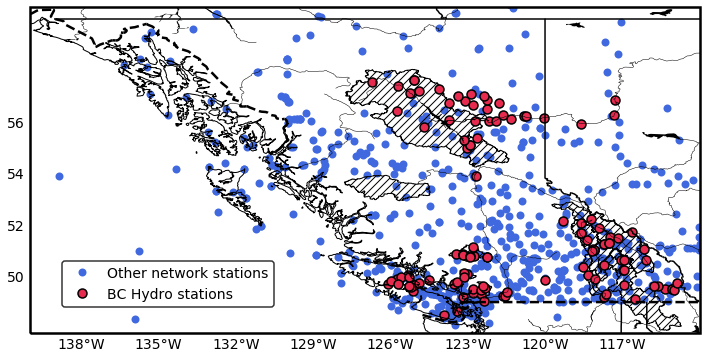

In [15]:
fig = plt.figure(figsize=(16*0.75, 12*0.75))
ax = fig.gca(projection=ccrs.PlateCarree())
ax.set_extent([-140, -114, 47.8, 60.2], ccrs.Geodetic())
ax.add_feature(cfeature.LAND.with_scale(scale_param), facecolor='w')
ax.add_feature(cfeature.COASTLINE.with_scale(scale_param), zorder=5)
ax.add_feature(cfeature.BORDERS.with_scale(scale_param), linestyle='--', linewidth=2.5, zorder=5)
ax.add_feature(PROVINCE, edgecolor='k', linestyle='-', linewidth=1.5, zorder=5)
ax.add_feature(cfeature.LAKES.with_scale(scale_param), linewidth=0, facecolor='k', zorder=5)
ax.add_feature(cfeature.RIVERS.with_scale(scale_param), linewidth=0.5, edgecolor='k', zorder=5)
ax.outline_patch.set_linewidth(2.5)

ax.add_geometries(Reader(shape_dir).geometries(), ccrs.PlateCarree(),
                  facecolor='none', edgecolor='k', hatch='///', zorder=4)

GL = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0)
GL.xlabels_top = False
GL.ylabels_right = False
GL.xformatter = LONGITUDE_FORMATTER
GLyformatter = LATITUDE_FORMATTER
GL.xlabel_style = {'size': 14}
GL.ylabel_style = {'size': 14}
GL.ylocator = mticker.FixedLocator([50, 52, 54, 56])
#GL.xlocator = mticker.FixedLocator([-126, -122, -118])

ax.plot(emwx_lon, emwx_lat, 'bo', mfc=RB, ms=8, mec='k', mew=0, zorder=2, label='Other network stations')
ax.plot(stn_lon, stn_lat, 'ro', mfc=AM, ms=9, mec='k', mew=1.5, zorder=5, label='BC Hydro stations')

LG = ax.legend(bbox_to_anchor=(0.375, 0.15), ncol=1, prop={'size':14});
LG.get_frame().set_facecolor('white')
LG.get_frame().set_edgecolor('k')
LG.get_frame().set_linewidth(1.5)

fig.savefig('/Users/yingkai/Desktop/comps/BCH_stations.png', dpi=250, orientation='portrait', \
           papertype='a4', format='png', bbox_inches='tight', pad_inches=0.1)

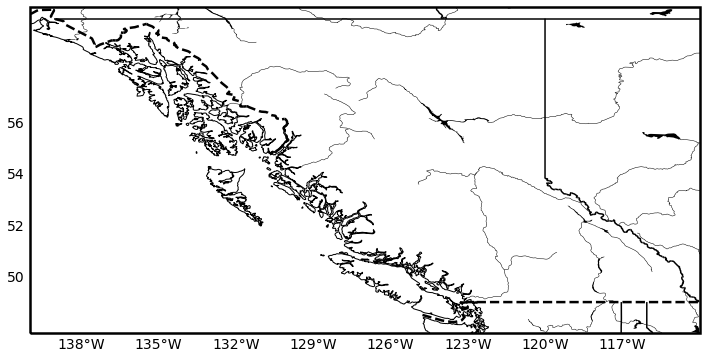

In [14]:
fig = plt.figure(figsize=(16*0.75, 12*0.75))
ax = fig.gca(projection=ccrs.PlateCarree())
ax.set_extent([-140, -114, 47.8, 60.2], ccrs.Geodetic())
ax.add_feature(cfeature.LAND.with_scale(scale_param), facecolor='w')
ax.add_feature(cfeature.COASTLINE.with_scale(scale_param), zorder=5)
ax.add_feature(cfeature.BORDERS.with_scale(scale_param), linestyle='--', linewidth=2.5, zorder=5)
ax.add_feature(PROVINCE, edgecolor='k', linestyle='-', linewidth=1.5, zorder=5)
ax.add_feature(cfeature.LAKES.with_scale(scale_param), linewidth=0, facecolor='k', zorder=5)
ax.add_feature(cfeature.RIVERS.with_scale(scale_param), linewidth=0.5, edgecolor='k', zorder=5)
ax.outline_patch.set_linewidth(2.5)

#ax.add_geometries(Reader(shape_dir).geometries(), ccrs.PlateCarree(),
#                  facecolor='none', edgecolor='k', hatch='///', zorder=4)

GL = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0)
GL.xlabels_top = False
GL.ylabels_right = False
GL.xformatter = LONGITUDE_FORMATTER
GLyformatter = LATITUDE_FORMATTER
GL.xlabel_style = {'size': 14}
GL.ylabel_style = {'size': 14}
GL.ylocator = mticker.FixedLocator([50, 52, 54, 56])
#GL.xlocator = mticker.FixedLocator([-126, -122, -118])

fig.savefig('/Users/yingkai/Desktop/comps/BC_map.png', dpi=250, orientation='portrait', \
           papertype='a4', format='png', bbox_inches='tight', pad_inches=0.1)

In [122]:
# BC Hydro station observation
temp = np.load('/Users/yingkai/Repository/WRFT/_data/Satellite/GPM/BCH_obs_Nov_2017.npy')
stn_lon = temp[()]['stn_lon']
stn_lat = temp[()]['stn_lat']
stn_code = np.array(temp[()]['stn_code'])
# train/test split: 20 data poiunts for test
# ===== #
# For reproducing the result, here the "random" is hard coded. Cannon use seed because of the Monte Carlo later. 
## withhold = sorted(np.random.randint(len(stn_lon), size=20)) # <--- original version
stn_test_temp = ['ALU', 'BRI', 'COX', 'DAI', 'DOW', 'ERC', 'FDL', 'FST', 'HEB', 'HFF', \
                 'MSK', 'PNK', 'PYN', 'STV', 'WOL', 'YPW', 'YXJ', 'YZY']
withhold = []
for test_code in stn_test_temp:
    withhold.append(np.where(stn_code==test_code))
# ==== #
withhold_flag = np.in1d(np.arange(len(stn_lon)).astype(int), withhold)
# test
test_lon = stn_lon[withhold_flag]
test_lat = stn_lat[withhold_flag]
# train
train_lon = stn_lon[~withhold_flag]
train_lat = stn_lat[~withhold_flag]

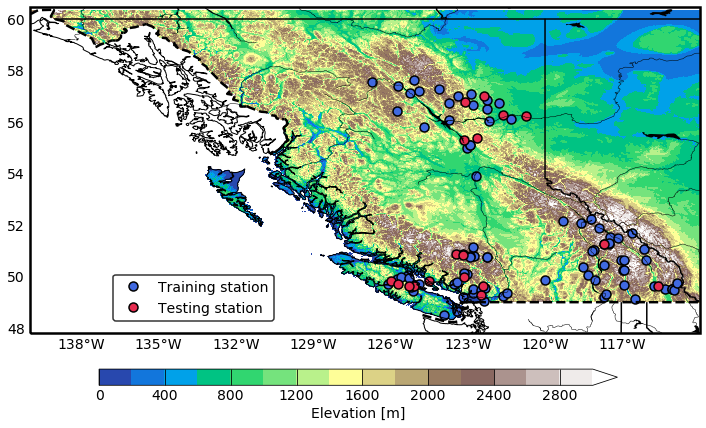

In [132]:
fig = plt.figure(figsize=(16*0.75, 12*0.75))
ax = fig.gca(projection=ccrs.PlateCarree())

ax.set_extent([-140, -114, 47.8, 60.2], ccrs.Geodetic())
ax.add_feature(cfeature.LAND.with_scale(scale_param), facecolor='w')
ax.add_feature(cfeature.COASTLINE.with_scale(scale_param), zorder=5)
ax.add_feature(cfeature.BORDERS.with_scale(scale_param), linestyle='--', linewidth=2.5, zorder=5)
ax.add_feature(PROVINCE, edgecolor='k', linestyle='-', linewidth=1.5, zorder=5)
ax.add_feature(cfeature.LAKES.with_scale(scale_param), linewidth=0, facecolor='k', zorder=5)
ax.add_feature(cfeature.RIVERS.with_scale(scale_param), linewidth=0.5, edgecolor='k', zorder=5)
ax.outline_patch.set_linewidth(2.5)

# ax.add_geometries(Reader(shape_dir).geometries(), ccrs.PlateCarree(),
#                   facecolor='none', edgecolor='k', hatch='///')

GL = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0)
GL.xlabels_top = False
GL.ylabels_right = False
GL.xformatter = LONGITUDE_FORMATTER
GLyformatter = LATITUDE_FORMATTER
GL.xlabel_style = {'size': 14}
GL.ylabel_style = {'size': 14}
GL.ylocator = mticker.FixedLocator([48, 50, 52, 54, 56, 58, 60])
#GL.xlocator = mticker.FixedLocator([-119, -117, -115])
CS = ax.contourf(nav_lon, nav_lat, CDEM, topo_level, cmap=plt.cm.terrain, extend='max')
ax.plot(train_lon, train_lat, 'ro', mfc=RB, ms=9, mec='k', mew=1.5, zorder=4, label='Training station')
ax.plot(test_lon, test_lat, 'ro', mfc=AM, ms=9, mec='k', mew=1.5, zorder=4, label='Testing station')

LG = ax.legend(bbox_to_anchor=(0.375, 0.2), ncol=1, prop={'size':14});
LG.get_frame().set_facecolor('white')
LG.get_frame().set_edgecolor('k')
LG.get_frame().set_linewidth(1.5)

cax = fig.add_axes([0.205, 0.17, 0.6, 0.025]) 
CBar = plt.colorbar(CS, orientation='horizontal', cax=cax)  
CBar.ax.tick_params(axis='x', labelsize=14, direction='in', length=16)
CBar.set_label('Elevation [m]', fontsize=14)

fig.savefig('/Users/yingkai/Desktop/GPR_high_quality/stations.png', dpi=250, orientation='portrait', \
           papertype='a4', format='png', bbox_inches='tight', pad_inches=0.1)